## Lecture 2 – Optimal Stopping / Asian-like Payoff

In this notebook, we will develop a class to simulate stock price dynamics and use Monte Carlo methods to price an Asian-like payoff and optimize a stopping strategy. In the first part, we will compare the value obtained using the Monte Carlo method to the theoretical value. Then, we will compute the stopping time strategies proposed in the lecture notes and additionally test a heuristic strategy.

### Monte Carlo methods to compute the price of the payoff

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import optuna

rng = np.random.default_rng()

class StockSimulator:
    def __init__(self, S0, sigma, dt, N):
        self.S0 = S0
        self.sigma = sigma
        self.dt = dt
        self.N = N

    def simulate_stock(self, M):
        """ 
        Simulate M trajectories of stock prices following geometric Brownian motion
        """
        epsilon = rng.standard_normal((M, self.N))
        prices = np.exp(np.cumsum((-0.5 * self.sigma**2 * self.dt + self.sigma * np.sqrt(self.dt) * epsilon), axis=1))
        prices = np.column_stack((np.full(M, self.S0), prices * self.S0))
        
        return prices
    
    def simulate_trajectory(self, M):
        """
        Simulate both stock prices and running averages over M trajectories.
        """
        prices = self.simulate_stock(M)
        running_average = np.cumsum(prices, axis=1) / np.arange(1, self.N + 2)

        return prices, running_average

    def monte_carlo_AN_SN(self, M):
        """
        Perform M Monte Carlo simulations to estimate E[A_N / S_N].
        """
        prices, running_avg = self.simulate_trajectory(M)
        A_N = running_avg[:, -1]
        S_N = prices[:, -1]
        payoffs = A_N / S_N
    
        return np.mean(payoffs)
    
def plot_trajectory(prices, running_avg):
    """ Helper function to plot a single trajectory of prices and running averages """
    plt.plot(prices[0], label='Stock Price (S)')
    plt.plot(running_avg[0], label='Running Average (A)')
    plt.xlabel('Time Step (n)')
    plt.ylabel('Price / Average')
    plt.legend()
    plt.title('Stock Price and Running Average Trajectory')
    plt.show()

if __name__ == "__main__":
    S0 = 10
    sigma = 0.2
    dt = 1 / 252
    N = 22
    M = 1000000 

    simulator = StockSimulator(S0, sigma, dt, N)
    
    estimated_AN_SN = simulator.monte_carlo_AN_SN(M)
    print(f"Estimated Payoff E[A_N / S_N]: {estimated_AN_SN}")

Estimated Payoff E[A_N / S_N]: 1.0017392004697752


### Theoretical value of the payoff

Let's now verify if our code appears to be correct by comparing it with the theoretical value:

We aim to calculate $ E\left(\frac{A_N}{S_N}\right) $ for an asset whose price follows a geometric Brownian motion.

### Let's develop $ E\left(\frac{A_N}{S_N}\right) $

We start by expressing $ E\left(\frac{A_N}{S_N}\right) $ as an average of the expectations of $ \frac{S_n}{S_N} $ for $ n = 0, 1, \dots, N $:
$$
E\left(\frac{A_N}{S_N}\right) = \frac{1}{N+1} \sum_{n=0}^N E\left(\frac{S_n}{S_N}\right)
$$
since the running average $ A_N $ is defined by the sum of $ S_n $ divided by $ N+1 $.

### Simplifying $ \frac{S_n}{S_N} $

$$
\frac{S_n}{S_N} = \exp\left(\frac{1}{2} \sigma^2 (N - n) \Delta t - \sigma \sqrt{(N - n) \Delta t} \, Z \right)
$$
where $ Z $ is a random variable defined as follows:
$$
Z = \frac{\sqrt{n \Delta t} \, Z_n - \sqrt{N \Delta t} \, Z_N}{\sqrt{(N - n) \Delta t}}
$$
Here, $ Z_n $ and $ Z_N $ are standard normal variables with time steps $ n $ and $ N $.
$$
Z \sim \mathcal{N}(0,1)
$$

We know for a standard normal variable $ Z $,
$$
E\left(\exp(a Z)\right) = \exp\left(\frac{a^2}{2}\right)
$$
Thus, with $ a = -\sigma \sqrt{(N - n) \Delta t} $, we obtain:
$$
E\left(\exp\left(-\sigma \sqrt{(N - n) \Delta t} \, Z\right)\right) = \exp\left(\frac{\sigma^2 (N - n) \Delta t}{2}\right)
$$

Using the result from the previous step, we find:
$$
E\left(\frac{S_n}{S_N}\right) = \exp\left(\frac{\sigma^2 (N - n) \Delta t}{2} + \frac{\sigma^2 (N - n) \Delta t}{2}\right) = \exp\left(\sigma^2 (N - n) \Delta t\right)
$$

### Conclusion: Calculating $ E\left(\frac{A_N}{S_N}\right) $

Substituting this value back into the initial sum, we obtain:
$$
E\left(\frac{A_N}{S_N}\right) = \frac{1}{N+1} \sum_{n=0}^N \exp\left(\sigma^2 (N - n) \Delta t\right)
$$
This sum is a geometric series with ratio $ \exp(-\sigma^2 \Delta t) $, which can be evaluated as follows:
$$
\sum_{n=0}^N \exp\left(\sigma^2 (N - n) \Delta t\right) = \exp(N \sigma^2 \Delta t) \frac{1 - \exp(-(N+1) \sigma^2 \Delta t)}{1 - \exp(-\sigma^2 \Delta t)}
$$
Thus, we obtain the simplified expression:
$$
E\left(\frac{A_N}{S_N}\right) = \frac{1}{N+1} \exp(N \sigma^2 \Delta t) \frac{1 - \exp(-(N+1) \sigma^2 \Delta t)}{1 - \exp(-\sigma^2 \Delta t)}
$$

By substituting the given values, we find approximately $ 1.001748 $, suggesting that our previous code appears correct.


### Now let's try the optimal strategy proposed in the lecture, let's modify the code:

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import optuna

rng = np.random.default_rng()

class StockSimulator:
    def __init__(self, S0, sigma, dt, N):
        self.S0 = S0
        self.sigma = sigma
        self.dt = dt
        self.N = N

    def simulate_stock(self, M):
        """ 
        Simulate M trajectories of stock prices following geometric Brownian motion
        """
        epsilon = rng.standard_normal((M, self.N))
        prices = np.exp(np.cumsum((-0.5 * self.sigma**2 * self.dt + self.sigma * np.sqrt(self.dt) * epsilon), axis=1))
        prices = np.column_stack((np.full(M, self.S0), prices * self.S0))
        
        return prices
    
    def simulate_trajectory(self, M):
        """
        Simulate both stock prices and running averages over M trajectories.
        """
        prices = self.simulate_stock(M)
        running_average = np.cumsum(prices, axis=1) / np.arange(1, self.N + 2)

        return prices, running_average

    def monte_carlo_AN_SN(self, M):
        """
        Perform M Monte Carlo simulations to estimate E[A_N / S_N].
        """
        prices, running_avg = self.simulate_trajectory(M)
        A_N = running_avg[:, -1]
        S_N = prices[:, -1]
        payoffs = A_N / S_N
    
        return np.mean(payoffs)
    
    
    def stopping_time(self, prices, running_avg, a):
        """
        Determine the stopping time tau_a for each trajectory where A_n >= a * S_n
        """
        stop_mask = running_avg >= a * prices
        tau = np.where(np.any(stop_mask, axis=1), np.argmax(stop_mask, axis=1), self.N)
        return tau
    
    def monte_carlo_payoff_tau(self, M, a):
        """
        Perform M Monte Carlo simulations to estimate E[A_tau / S_tau].
        """
        prices, running_avg = self.simulate_trajectory(M)
        tau = self.stopping_time(prices, running_avg, a)

        A_tau = running_avg[np.arange(M), tau]
        S_tau = prices[np.arange(M), tau]
        payoffs = A_tau / S_tau

        return np.mean(payoffs)

def plot_trajectory(prices, running_avg):
    """ Helper function to plot a single trajectory of prices and running averages """
    plt.plot(prices[0], label='Stock Price (S)')
    plt.plot(running_avg[0], label='Running Average (A)')
    plt.xlabel('Time Step (n)')
    plt.ylabel('Price / Average')
    plt.legend()
    plt.title('Stock Price and Running Average Trajectory')
    plt.show()


if __name__ == "__main__":
    S0 = 10
    sigma = 0.2
    dt = 1 / 252
    N = 22
    M = 200000  

    simulator = StockSimulator(S0, sigma, dt, N)

In [215]:
def objective(trial, simulator, M):
    """ Optuna objective function to optimize the stopping strategy parameter 'a' """
    a = trial.suggest_uniform('a', 1.0, 10.0)
    return simulator.monte_carlo_payoff_tau(M, a)


study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, simulator, M), n_trials=120)

best_a = study.best_params['a']
print(f"Optimal 'a' found by Optuna: {best_a}")


optimal_payoff_tau = simulator.monte_carlo_payoff_tau(M, best_a)
print(f"Optimal Expected Payoff E[A_tau_a / S_tau_a] (a={best_a}): {optimal_payoff_tau}")

[I 2024-10-30 16:31:55,155] A new study created in memory with name: no-name-9c6935ea-721c-42b0-a674-af96da2ce48d
/var/folders/hx/vwlhzfbs19l0t4dsjfz1rgch0000gn/T/ipykernel_70727/3952800536.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  a = trial.suggest_uniform('a', 1.0, 10.0)
[I 2024-10-30 16:31:55,356] Trial 0 finished with value: 1.0017834022174663 and parameters: {'a': 5.460359809764591}. Best is trial 0 with value: 1.0017834022174663.
[I 2024-10-30 16:31:55,497] Trial 1 finished with value: 1.0018704466669266 and parameters: {'a': 2.6355338742843006}. Best is trial 1 with value: 1.0018704466669266.
[I 2024-10-30 16:31:55,633] Trial 2 finished with value: 1.0017267006472406 and parameters: {'a': 5.066304518401289}. Best is trial 1 with value: 1.0018704466669266.
[I 2024-10-30 16:31:55,770] Trial 3 finished with value: 1.001570107949288

Optimal 'a' found by Optuna: 1.0142320273803032
Optimal Expected Payoff E[A_tau_a / S_tau_a] (a=1.0142320273803032): 1.0101118698621039


Thus, with Optuna, we find that for a value of a close to 1.016, we achieve a payoff of around 1.01, which is above the theoretical value, which is what we want.

Let's take a look at a graph to determine for which value of avwe have an optimal payoff."

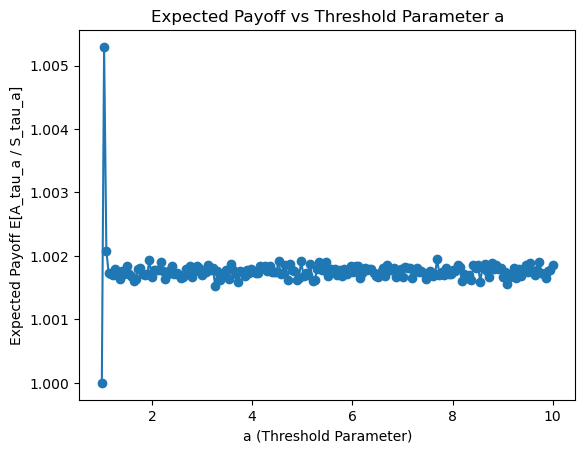

In [218]:
a_values = np.linspace(1.0, 10.0, 200)
payoffs = [simulator.monte_carlo_payoff_tau(M, a) for a in a_values]

plt.plot(a_values, payoffs, marker='o')
plt.xlabel("a (Threshold Parameter)")
plt.ylabel("Expected Payoff E[A_tau_a / S_tau_a]")
plt.title("Expected Payoff vs Threshold Parameter a")
plt.show()

We can see that the value of a where the expected payoff is the best is a near 1 so let's see with a lower interval.

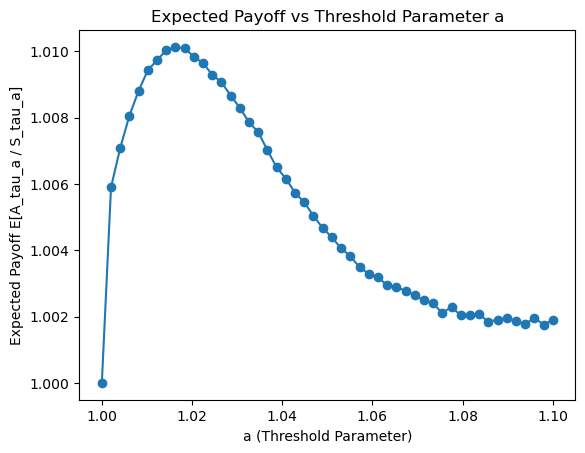

In [219]:
a_values = np.linspace(1.0, 1.1, 50)
payoffs = [simulator.monte_carlo_payoff_tau(M, a) for a in a_values]

plt.plot(a_values, payoffs, marker='o')
plt.xlabel("a (Threshold Parameter)")
plt.ylabel("Expected Payoff E[A_tau_a / S_tau_a]")
plt.title("Expected Payoff vs Threshold Parameter a")
plt.show()

With the graph we can see that the best value of a is the near 1.02

In [221]:
def objective(trial, simulator, M):
    """ Optuna objective function to optimize the stopping strategy parameter 'a' """
    a = trial.suggest_uniform('a', 1.0, 1.1)
    return simulator.monte_carlo_payoff_tau(M, a)  

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, simulator, M), n_trials=100)


best_a = study.best_params['a']
print(f"Optimal 'a' found by Optuna: {best_a}")

optimal_payoff_tau = simulator.monte_carlo_payoff_tau(M, best_a)
print(f"Optimal Expected Payoff E[A_tau_a / S_tau_a] (a={best_a}): {optimal_payoff_tau}")

[I 2024-10-30 16:35:50,742] A new study created in memory with name: no-name-59e464ad-d487-4744-a254-7f3b85aaeb37
/var/folders/hx/vwlhzfbs19l0t4dsjfz1rgch0000gn/T/ipykernel_70727/1941675734.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  a = trial.suggest_uniform('a', 1.0, 1.1)
[I 2024-10-30 16:35:50,913] Trial 0 finished with value: 1.0023314426463215 and parameters: {'a': 1.0769157261348297}. Best is trial 0 with value: 1.0023314426463215.
[I 2024-10-30 16:35:51,057] Trial 1 finished with value: 1.0075265813620564 and parameters: {'a': 1.0338023640339897}. Best is trial 1 with value: 1.0075265813620564.
[I 2024-10-30 16:35:51,200] Trial 2 finished with value: 1.0099151154741768 and parameters: {'a': 1.020568290936644}. Best is trial 2 with value: 1.0099151154741768.
[I 2024-10-30 16:35:51,338] Trial 3 finished with value: 1.002119648996042

Optimal 'a' found by Optuna: 1.0185304565905435
Optimal Expected Payoff E[A_tau_a / S_tau_a] (a=1.0185304565905435): 1.0100177663881678


We obtain almost the same results so this means that to achieve the highest expected return, the optimal strategy is to choose a stopping time $ \tau_a $ where the asset's price exceeds its past average by approximately 2%.


#### Bellamn's strategy

In [222]:
import numpy as np

class StockSimulator:
    def __init__(self, S0, sigma, dt, N):
        self.S0 = S0  
        self.sigma = sigma  
        self.dt = dt  
        self.N = N       
        self.rng = np.random.default_rng()  

    def simulate_stock(self, M):
        """Simulates M stock price trajectories over N time steps."""
        epsilon = self.rng.standard_normal((M, self.N))
        prices = np.exp(np.cumsum((-0.5 * self.sigma**2 * self.dt + self.sigma * np.sqrt(self.dt) * epsilon), axis=1))
        prices = np.column_stack((np.full(M, self.S0), prices * self.S0))
        return prices
    
    def simulate_trajectory(self, M):
        """Calculates the stock price trajectories and associated running averages."""
        prices = self.simulate_stock(M)
        running_average = np.cumsum(prices, axis=1) / np.arange(1, self.N + 2)
        return prices, running_average

    def bellman_optimization(self, M):
        """Bellman's dynamic programming to optimize the payoff."""
        prices, running_avg = self.simulate_trajectory(M)
        
        #we initialize the value table with the current payoff
        payoff = np.where(prices != 0, running_avg / prices, 0)
        value = np.zeros_like(payoff)
        
        value[:, -1] = payoff[:, -1] # we initialize the final value at time N
        
        # Backward induction to maximize the payoff
        for n in range(self.N - 1, -1, -1):
            immediate_payoff = payoff[:, n]
            value[:, n] = np.maximum(immediate_payoff, value[:, n + 1])

        # we get the optimal stopping time by taking the maximum
        tau = np.argmax(value == payoff, axis=1)
        
        # Get A_tau and S_tau for the final payoff calculation
        A_tau = running_avg[np.arange(M), tau]
        S_tau = prices[np.arange(M), tau]

        payoffs = np.where(S_tau != 0, A_tau / S_tau, 0)
        
        return np.mean(payoffs), tau

if __name__ == "__main__":
    S0 = 10         
    sigma = 0.2      
    dt = 1 / 252     
    N = 22           
    M = 200000       


    simulator = StockSimulator(S0, sigma, dt, N)
    optimal_payoff, tau = simulator.bellman_optimization(M)

    print(f"Expected optimal value E[A_tau / S_tau] using Bellman's dynamic programming: {optimal_payoff}")


Expected optimal value E[A_tau / S_tau] using Bellman's dynamic programming: 1.031673532723958


 So with the Bellman strategy, we obtain an expected payoff of approximately 1.0316, which is better than the expected payoff with the stopping time $ \tau_a $  

### Let's compare Bellman with others

In [223]:
import numpy as np
import matplotlib.pyplot as plt

class StockSimulator:
    def __init__(self, S0, sigma, dt, N):
        self.S0 = S0 
        self.sigma = sigma  
        self.dt = dt 
        self.N = N  
        self.rng = np.random.default_rng()  

    def simulate_stock(self, M):
        """Simulate M stock price trajectories following geometric Brownian motion."""

        epsilon = self.rng.standard_normal((M, self.N))
        prices = np.exp(np.cumsum((-0.5 * self.sigma**2 * self.dt + self.sigma * np.sqrt(self.dt) * epsilon), axis=1))
        prices = np.column_stack((np.full(M, self.S0), prices * self.S0))

        return prices
    
    def simulate_trajectory(self, M):
        """Simulate stock prices and their running averages."""

        prices = self.simulate_stock(M)  
        running_average = np.cumsum(prices, axis=1) / np.arange(1, self.N + 2)

        return prices, running_average

    def bellman_optimization(self, M):
        """Optimize the payoff using Bellman's dynamic programming."""
        prices, running_avg = self.simulate_trajectory(M)  
        
        payoff = np.where(prices != 0, running_avg / prices, 0)  # we initialize the value table with the current payoff
        value = np.zeros_like(payoff)
        
        value[:, -1] = payoff[:, -1]  # we initialize the final value at time N
        
        # Backward induction to maximize the payoff
        for n in range(self.N - 1, -1, -1):
            immediate_payoff = payoff[:, n]
            value[:, n] = np.maximum(immediate_payoff, value[:, n + 1])  # maximum between immediate payoff and future value

        
        tau = np.argmax(value == payoff, axis=1) # we find the optimal stopping 
        
        A_tau = running_avg[np.arange(M), tau]
        S_tau = prices[np.arange(M), tau]

        
        payoffs = np.where(S_tau != 0, A_tau / S_tau, 0)
        
        return np.mean(payoffs), tau  

    def adaptive_threshold(self, M):
        """Strategy 1: Adaptive Average Value.

        This method determines the stopping time where the ratio of the 
        running average to the stock price exceeds the average payoff.
        """
        prices, running_avg = self.simulate_trajectory(M)  
        avg_payoff = np.mean(running_avg[:, -1] / prices[:, -1])  # Final average payoff

        # Find the stopping time where the ratio exceeds the average
        tau = np.array([np.argmax(running_avg[i] / prices[i] >= avg_payoff) for i in range(M)])
        A_tau = running_avg[np.arange(M), tau]
        S_tau = prices[np.arange(M), tau]
        
        payoffs = np.where(S_tau != 0, A_tau / S_tau, 0)
        return np.mean(payoffs) 

    def empirical_max_strategy(self, M):
        """Strategy 2: Empirical Maximum Value.

        This strategy identifies the stopping time based on the maximum ratio 
        of the running average to the stock price over M trajectories.
        """
        prices, running_avg = self.simulate_trajectory(M)  
        max_ratio = np.max(running_avg / prices, axis=1)

        # Find the stopping time based on the maximum ratio
        tau = np.array([np.argmax(running_avg[i] / prices[i] == max_ratio[i]) for i in range(M)])
        A_tau = running_avg[np.arange(M), tau]
        S_tau = prices[np.arange(M), tau]

        payoffs = np.where(S_tau != 0, A_tau / S_tau, 0)
        return np.mean(payoffs)  

    def regression_based_threshold(self, M):
        """Strategy 3: Linear Regression Based Threshold.

        This method applies linear regression to determine when the ratio of 
        the running average to the stock price first exceeds a fitted trend line.
        """
        prices, running_avg = self.simulate_trajectory(M)
        ratios = running_avg / prices 
    
        tau = []
        for i in range(M):
            x = np.arange(self.N + 1)  # time indices
            y = ratios[i]  # Ratios for trajectory i
        
            # Apply linear regression to get the trend
            slope, intercept = np.polyfit(x, y, 1)
            trend_line = slope * x + intercept
            
            # Determine the first point where the ratio exceeds the trend
            tau.append(np.argmax(y >= trend_line))

        A_tau = running_avg[np.arange(M), tau]
        S_tau = prices[np.arange(M), tau]
        payoffs = np.where(S_tau != 0, A_tau / S_tau, 0)
        return np.mean(payoffs)  



if __name__ == "__main__":
    S0 = 10
    sigma = 0.2
    dt = 1 / 252
    N = 22
    M = 500000

    simulator = StockSimulator(S0, sigma, dt, N)
    
    # Bellman Strategy
    bellman_payoff = simulator.bellman_optimization(M)
    print(f"Expected payoff with Bellman Strategy: {bellman_payoff[0]}")

    # Strategy 1: Adaptive Average Value
    adaptive_payoff = simulator.adaptive_threshold(M)
    print(f"Expected payoff with Adaptive Threshold: {adaptive_payoff}")

    # Strategy 2: Empirical Maximum Value
    empirical_max_payoff = simulator.empirical_max_strategy(M)
    print(f"Expected payoff with Empirical Maximum Value: {empirical_max_payoff}")

    # Strategy 3: Linear Regression Based Threshold
    regression_payoff = simulator.regression_based_threshold(M)
    print(f"Expected payoff with Linear Regression Based Threshold: {regression_payoff}")


Expected payoff with Bellman Strategy: 1.0316658890228545
Expected payoff with Adaptive Threshold: 1.007032090860656
Expected payoff with Empirical Maximum Value: 1.031731609042935
Expected payoff with Linear Regression Based Threshold: 1.0068612179249672


We can see that the Bellman Strategy is the best strategy, along with the Empirical Maximum Value Strategy, we got an expected payoff of around 1.0316. Therefore, the best strategy we have observed in this lecture is the Bellman Strategy for this geometric Brownian motion with r=0.